In [1]:
import sys
sys.path.append('C:\\Users\\sumaiyah\\Documents\\Univeristy\\diss\\misuse-AIaaS')

# Import filepaths
from notebooks import FIC_10minute_7days_filepath

In [2]:
import numpy as np
import pandas as pd
from timeit import default_timer as timer
import matplotlib.pyplot as plt

from timeit import default_timer as timer
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.utils import to_time_series_dataset

In [3]:
FIC_10minute_7days_df = pd.read_pickle(FIC_10minute_7days_filepath)

In [4]:
FIC_10minute_7days_df['HashOwner'].value_counts()

fd8a2430aa1d1b6fb9e059ff6268eabf8bbd77e68a6d5f38195a67820149b0ab    1975
486e10ac87f2c7495ab672094483c49e935e6f7e19b2b9b7157be7f9f949244c     933
f0417cb85bd1c751561867f042b6623bc7885e27669a11bc7f9a64dd7d3e4eb9     630
23585e5c9ad9d7de0016aee0cae0ef9339aa943e635a0d61af082dbfe4688c40     317
7443ba68131cffcdf846c2c74a7f0030cf19240d7e97e3c7f3d22324a065d5ca     314
                                                                    ... 
f18ac4c3371d2b93ee860e16367cee9ace91806e8cc6239cf5f8284f0edf3afe       1
84d1e9b84bcdf43d69e1819f84c6591771cfe18783526901874b8bfdd2624670       1
5e93959adc478670b62c51d3849b9241689545c2cd983e4fa37f152d7f4c79a8       1
8f8c5ff9a345c716d8926ad95fcbf3590b852101592211d1f1e548cbc3e2d749       1
a297c6418288578dbb73bb4f99fed5f634569ce1862094c637c74a3bb2424bab       1
Name: HashOwner, Length: 13192, dtype: int64

In [5]:
single_tenant_df = FIC_10minute_7days_df[FIC_10minute_7days_df['HashOwner'] == 'fd8a2430aa1d1b6fb9e059ff6268eabf8bbd77e68a6d5f38195a67820149b0ab']

# Preprocess data
single_tenant_df = single_tenant_df.drop(columns=['HashOwner', 'HashApp', 'HashFunction', 'Trigger'])
single_tenant_df = TimeSeriesScalerMeanVariance().fit_transform(single_tenant_df)

# Need values in specific shape for tslearn clustering
single_tenant_vals = to_time_series_dataset(single_tenant_df)
print(single_tenant_vals.shape)

(1975, 1008, 1)


# DBScan

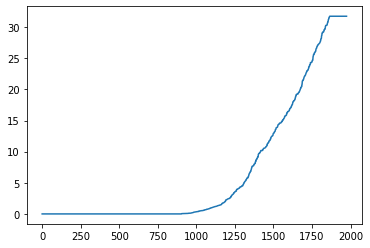

In [6]:
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt

# ideal value for ε will be equal to the distance value at the point of maximum curvature
# ended up looping through combinations of MinPts and ε values slightly above and below the values estimated here to find the model of best fit

neighbors = NearestNeighbors(n_neighbors=20)
neighbors_fit = neighbors.fit(single_tenant_vals[:,:,0])
distances, indices = neighbors_fit.kneighbors(single_tenant_vals[:,:,0])

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [7]:
from sklearn.cluster import DBSCAN

start = timer()

db = DBSCAN(eps=15, min_samples=10).fit(single_tenant_vals[:,:144,0])
labels = pd.Series(db.labels_)

end = timer()
print('Clustering took %f seconds' % ((end - start)))

print(labels.value_counts())
print(list(labels.value_counts().values))

Clustering took 0.182197 seconds
 0    1664
-1     184
 2      44
 1      24
 6      20
 5      18
 3      11
 4      10
dtype: int64
[1664, 184, 44, 24, 20, 18, 11, 10]


In [8]:
k=7

print('Results of K-means Clustering with k=%d' % k)

start = timer()

km = TimeSeriesKMeans(n_clusters=k, verbose=False, random_state=42, n_jobs=-1)
kmeans_predictions = km.fit_predict(single_tenant_vals)

end = timer()
print('Clustering k=%d took %f seconds' % (k, (end - start)))

km_clusters = pd.Series(kmeans_predictions)
print(km_clusters.value_counts())
print(km_clusters.value_counts().values.tolist(), '\n')

Results of K-means Clustering with k=7
Clustering k=7 took 1.419984 seconds
4    1752
2     110
3      54
5      23
6      21
1      11
0       4
dtype: int64
[1752, 110, 54, 23, 21, 11, 4] 



In [9]:
print('Results of dtw K-means Clustering with k=%d' % k)

start = timer()

dtwkm = TimeSeriesKMeans(n_clusters=k, verbose=True, random_state=42, n_jobs=-1, metric='dtw')
dtwkmeans_predictions = dtwkm.fit_predict(single_tenant_vals)

end = timer()
print('Clustering k=%d took %f seconds' % (k, (end - start)))

dtwkm_clusters = pd.Series(dtwkmeans_predictions)
print(dtwkm_clusters.value_counts())
print(dtwkm_clusters.value_counts().values.tolist(), '\n')

Results of dtw K-means Clustering with k=7


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 1975 out of 1975 | elapsed:   16.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:   13.9s
[Parallel(n_jobs=

250.886 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:   50.7s
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:   58.8s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 11242 tasks  

151.506 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:   36.9s
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:   43.5s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:   50.6s
[Parallel(n_jobs=-1)]: Done 11242 tasks  

145.572 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:   31.2s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:   44.5s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:   51.6s
[Parallel(n_jobs=-1)]: Done 11242 tasks  

144.063 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:   37.0s
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:   50.7s
[Parallel(n_jobs=-1)]: Done 11242 tasks  

143.358 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:   43.7s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:   50.8s
[Parallel(n_jobs=-1)]: Done 11242 tasks  

143.289 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:   37.0s
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:   43.7s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:   50.8s
[Parallel(n_jobs=-1)]: Done 11242 tasks  

143.278 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:   36.9s
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:   50.7s
[Parallel(n_jobs=-1)]: Done 11242 tasks  

143.246 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:   43.7s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:   50.8s
[Parallel(n_jobs=-1)]: Done 11242 tasks  

143.222 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:   16.3s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:   31.7s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:   44.5s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:   51.8s
[Parallel(n_jobs=-1)]: Done 11242 tasks  

143.222 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed:   26.0s
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed:   47.1s
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:   55.9s
[Parallel(n_jobs=-1)]: Done 11242 tasks  

Clustering k=7 took 4241.451266 seconds
4    432
3    393
0    374
2    314
6    192
1    182
5     88
dtype: int64
[432, 393, 374, 314, 192, 182, 88] 



[Parallel(n_jobs=-1)]: Done 13825 out of 13825 | elapsed:  1.3min finished


# Results

In [12]:
colours = ['tab:red', 'tab:orange', 'gold', 'tab:green', 'tab:blue', 'tab:purple', 'tab:pink', 'tab:brown', 'k', 'tab:gray']

In [19]:
data_df = pd.DataFrame(single_tenant_df[:, :, 0])
data_df['dbscan'] = labels
average_dbscan_cluster = data_df.groupby('dbscan').mean()

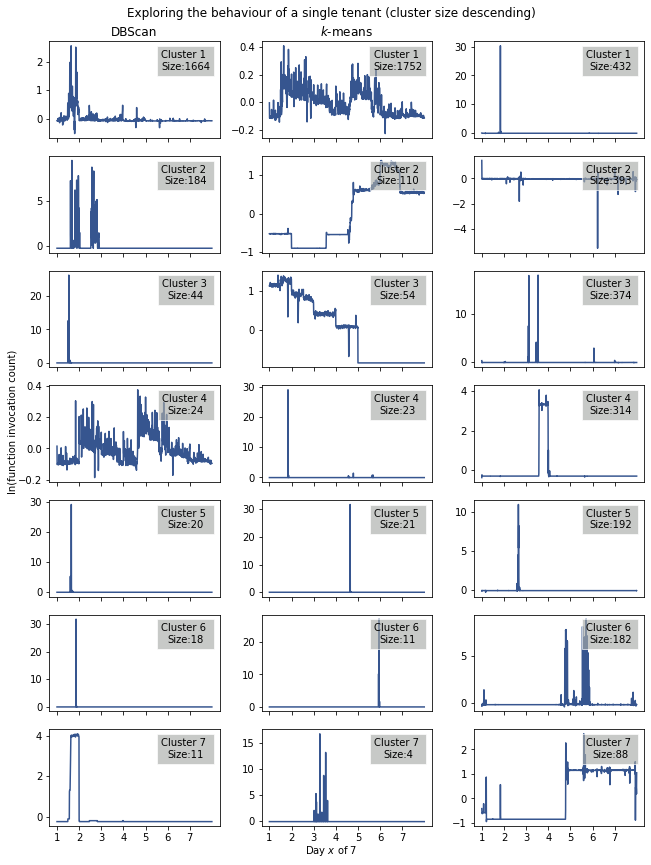

In [57]:
fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(9, 12), sharex=True, tight_layout = True)
colours = ['tab:red', 'tab:orange', 'gold', 'tab:green', 'tab:blue', 'tab:purple', 'tab:pink', 'tab:gray', 'tab:brown']

# Row and column labels for subplot
cols = ['DBScan', '$k$-means']
for ax, col in zip((axes[0,0], axes[0,1]), cols):
    ax.set_title(col)

fig.text(0.5, 0, 'Day $x$ of 7', ha='center')
fig.text(0, 0.5, 'ln(function invocation count)', va='center', rotation='vertical')
fig.suptitle('Exploring the behaviour of a single tenant (cluster size descending)')

# DBScan
cluster_order = pd.Series(labels).value_counts().keys().tolist()[0:7]
for yi in range(len(cluster_order)):
    cluster_index = cluster_order[yi]
    axes[yi,0].plot(average_dbscan_cluster.values[cluster_index], color='#36558F')  
    
    # Plot text in same position in each subplot
    text = 'Cluster %d \nSize:%d' % ((yi + 1), pd.Series(labels).value_counts().values[yi])
    t= axes[yi,0].text(0.8, 0.8, text,
             horizontalalignment='center',
             verticalalignment='center',
             transform = axes[yi,0].transAxes,
             color="black")
    t.set_bbox(dict(facecolor='#A9ACA9', alpha=0.65, edgecolor='white'))

# Kmeans
cluster_order = pd.Series(kmeans_predictions).value_counts().keys().tolist()
for yi in range(len(cluster_order)):
    cluster_index = cluster_order[yi]
    axes[yi,1].plot(km.cluster_centers_[cluster_index].ravel()[:int(7 * (1440 / 10))], color='#36558F')
    
    # Plot text in same position in each subplot
    text = 'Cluster %d \nSize:%d' % ((yi + 1), pd.Series(kmeans_predictions).value_counts().values[yi])
    t= axes[yi,1].text(0.8, 0.8, text,
             horizontalalignment='center',
             verticalalignment='center',
             transform = axes[yi,1].transAxes,
             color='black')
    t.set_bbox(dict(facecolor='#A9ACA9', alpha=0.65, edgecolor='white'))

# Dynamic Time warped k-means
cluster_order = pd.Series(dtwkmeans_predictions).value_counts().keys().tolist()
for yi in range(len(cluster_order)):
    cluster_index = cluster_order[yi]
    axes[yi,2].plot(dtwkm.cluster_centers_[cluster_index].ravel()[:int(7 * (1440 / 10))], color='#36558F')
    
    # Plot text in same position in each subplot
    text = 'Cluster %d \nSize:%d' % ((yi + 1), pd.Series(dtwkmeans_predictions).value_counts().values[yi])
    t= axes[yi,2].text(0.8, 0.8, text,
             horizontalalignment='center',
             verticalalignment='center',
             transform = axes[yi,2].transAxes,
             color='black')
    t.set_bbox(dict(facecolor='#A9ACA9', alpha=0.65, edgecolor='white'))

x_ticks = np.arange(0, 1008, 144)
plt.xticks(x_ticks, values)
# plt.xticks(list(range(1008)), values)

fig.tight_layout()
fig.savefig('figs/final/test4f.png', dpi=250)
plt.show()

| Clustering Algorithm | Clusters                           | Clustering Time (s) |
|----------------------|------------------------------------|---------------------|
| DBScan               | [1664, 44, 24, 20, 18, 11, 10]     | 0.162274            |
| $k$-means            | [1752, 110, 54, 23, 21, 11, 4]     | 0.814314            |
| dtw $k$-means        | [432, 393, 374, 314, 192, 182, 88] | 4241.451266         |